## Some useful imports

In [2]:
import nltk
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

## Getting email text

In [3]:
emails = pd.read_csv("./hillary-clinton-emails/Emails.csv", usecols=["RawText"])

In [3]:
emails.head()

,RawText
0,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


Concatenating all the e-mails into one big text.

In [4]:
original_text = " ".join(emails.RawText)

### First raw word count 

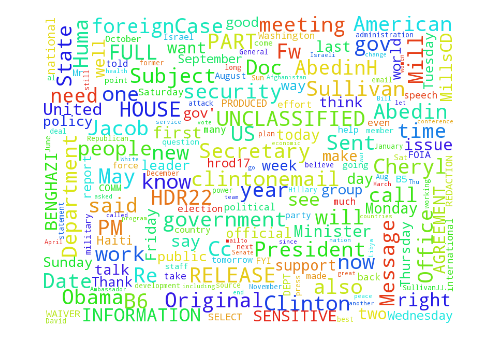

In [5]:
def show_wordCloud(text):
    # lower max_font_size
    wordcloud = WordCloud(
        max_font_size=40, 
        background_color='white',
        width=800,
        height=600
    ).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

show_wordCloud(original_text)

We can see different kind of patterns:
- generic words in emails: re, part, date, sent, subject, message
- classical words: will, want, many
- uppercase vs lowercase
- accronyms
- etc.

Pros:
- no processing, pure data: no risk of having drop important part or change the meaning

Cons:
- difficult to extract important words: they are hidden in the mass
- not homogenous: year and years are counted separately
- noisy: some words do not have a single meaning themselves, the need a context (e.g. stop words)

## Processing pipeline

Here is the pipeline we choosed to implement:
- tokenization
- lowercasing
- stop word removal
- lemmatization
- stemming
- url/email removal: although they not appear in the world cloud url are often present in mails and can be blacklisted with `./_@:` which are usally part of desired words

In [6]:
tokens = nltk.word_tokenize(original_text)

In [7]:
def lower_case(tokens):
    return [token.lower() for token in tokens]

tokens = lower_case(tokens)

In [8]:
def remove_stop_words(tokens):
    return np.array(tokens)[np.in1d(tokens, stopwords.words("english"), invert=True)]

tokens = remove_stop_words(tokens)

In [9]:
def lemmatization(tokens):
    wordnet_lemmatizer = WordNetLemmatizer()
    return [wordnet_lemmatizer.lemmatize(token) for token in tokens]

tokens = lemmatization(tokens)

In [10]:
def stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

tokens = stemming(tokens)

In [11]:
def remove_url_email(tokens):
    blacklist_chars = ['_', '.', ':' , '@', '/']
    return [token for token in tokens if not np.in1d(list(token), blacklist_chars).any()]
    
tokens = remove_url_email(tokens)

In [12]:
text = " ".join(tokens)

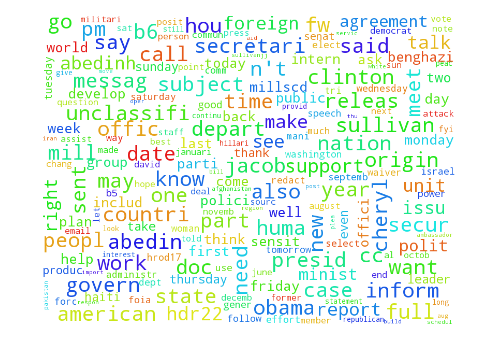

In [13]:
show_wordCloud(text)

The result has improved a lot, however there are still issues:
- generic words in emails: this would require extending the stop words list with targetted words and would require more analysis
- classical words: this would require extending the stop words list or use "zpif score" to avoid considering them
- accronyms: this would require to generate a list corresponding term which is indeed a hard problem

Pros:
- more variaty, more homogenous
- similar words put together whenever possible
- avoid stop words
    
Cons:
- might have influence the content: in case pipeline/methods introducing some biais
- still some issues with normalization: n't should be here

## Only nouns

One could also try to keep only (proper) nouns as verbs, adjectives and adverbs might have a very generic meaning (e.g. also, send). Using a POS tagging just after tokenization, we can discard the others.

In [76]:
def keep_nouns(tokens, to_keep_tag = ['NN', 'NNS', 'NNP', 'NNPS']):
    tags = nltk.pos_tag(set(tokens))
    to_keep_tokens = [tok for tok, tag in tags if tag in to_keep_tag]
    return np.array(tokens)[np.in1d(tokens, to_keep_tokens)]

In [15]:
tokens2 = nltk.word_tokenize(original_text)
tokens2 = keep_nouns(tokens2)
tokens2 = lower_case(tokens2)
tokens2 = remove_stop_words(tokens2)
tokens2 = lemmatization(tokens2)
tokens2 = stemming(tokens2)
tokens2 = remove_url_email(tokens2)

In [16]:
nouns = " ".join(tokens2)

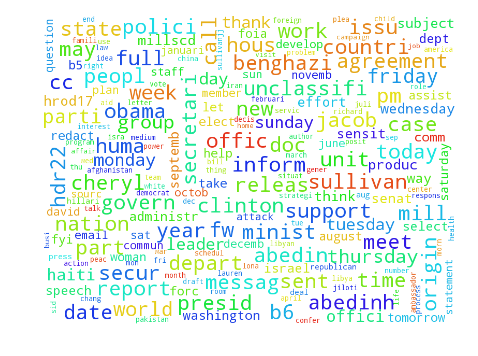

In [17]:
show_wordCloud(nouns)

Although this is more aggressive than the previous trials, this world cloud gives a better overview of the general content. The non-nouns are might be due to english verbs/nouns duality.

We wanted here to achieve some sort of Luhn's analysis. We could also have taken word frequencies for each document and only kept the words which are not frequent in all mails.

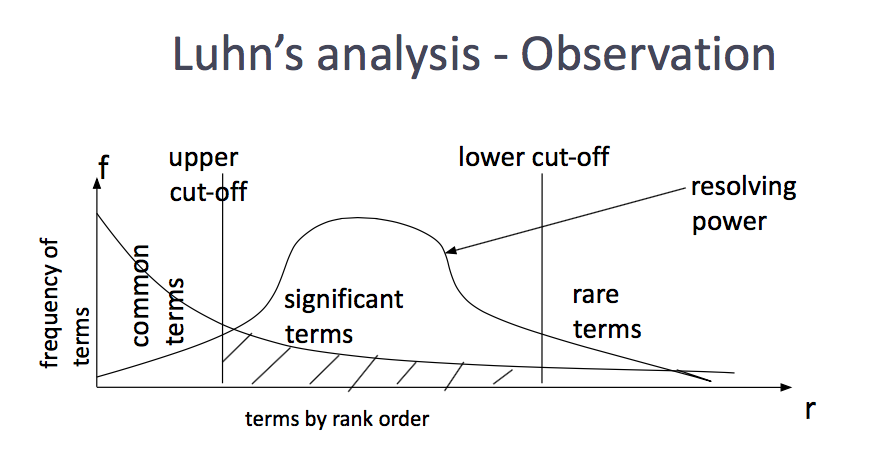

In [18]:
from IPython.display import Image
Image(filename="./luhn's analysis.png")

## Part 2

In [78]:
import pycountry

In [83]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [85]:
sid = SentimentIntensityAnalyzer()

We use compoud to define the sentiment of the text.
https://www.linkedin.com/pulse/sentiment-analysis-using-vader-muthuraj-kumaresan

In [ ]:
sentiment_df = pd.DataFrame(columns=["compound", "neutral", "negative", "positive"])

i = 0
for email in emails.RaaaawText:
    score = sid.polarity_scores(email)
    sentiment_df.loc[i] = (score["compound"], score["neu"], score["neg"], score["pos"])
    i += 1

In [54]:
sentiment_df.to_csv("sentiment_vader.csv")

In [157]:
sentiment_df = pd.read_csv("./sentiment_vader.csv", index_col=0)

In [158]:
sentiment_df.describe()

,compound,neutral,negative,positive
count,7945.000000,7945.000000,7945.000000,7945.000000
mean,-0.102229,0.832517,0.095896,0.071455
std,0.765921,0.048518,0.042428,0.050764
min,-1.000000,0.000000,0.000000,0.000000
25%,-0.778300,0.804000,0.064000,0.033000
50%,-0.433300,0.837000,0.088000,0.067000
75%,0.817600,0.865000,0.121000,0.103000
max,1.000000,0.978000,0.281000,0.324000


In [204]:
countries = [(country.name.lower(), country.alpha_2.lower(), country.alpha_3.lower()) for country in pycountry.countries]

In [205]:
sentiment_per_country = pd.DataFrame(columns=["country", "pos","neg"]).set_index("country")

In [206]:
for name, _, _ in countries:
    sentiment_per_country.loc[name] = 0

In [209]:
i = 0
for email in emails.RawText:
    add = 0
    sentiment = sentiment_df.loc[i]["compound"]
    
    tokens = nltk.word_tokenize(email)
    nouns = keep_nouns(tokens, ["NN", "NNP", "NNPS"])
    country_found = ["norway"]
    # find countries
    for noun in nouns:
        lc_noun = noun.lower()
        index = 0
        for name, a2, a3 in countries:
            if name not in country_found and (lc_noun == name or lc_noun == a2 or lc_noun == a3):
                country_found.append(name)
                if sentiment >= 0:
                    sentiment_per_country.pos.loc[name] += 1
                if sentiment < 0:
                    sentiment_per_country.neg.loc[name] += 1
    i += 1

In [210]:
sentiment_per_country.describe()

,pos,neg
count,249.000000,249.000000
mean,66.939759,76.534137
std,290.262674,391.193511
min,0.000000,0.000000
25%,2.000000,1.000000
50%,9.000000,8.000000
75%,34.000000,25.000000
max,3285.000000,4790.000000


In [214]:
sentiment_per_country_pos = sentiment_per_country[(sentiment_per_country.pos > 67) | (sentiment_per_country.neg > 76)]

In [215]:
sentiment_per_country_pos.shape

(34, 2)

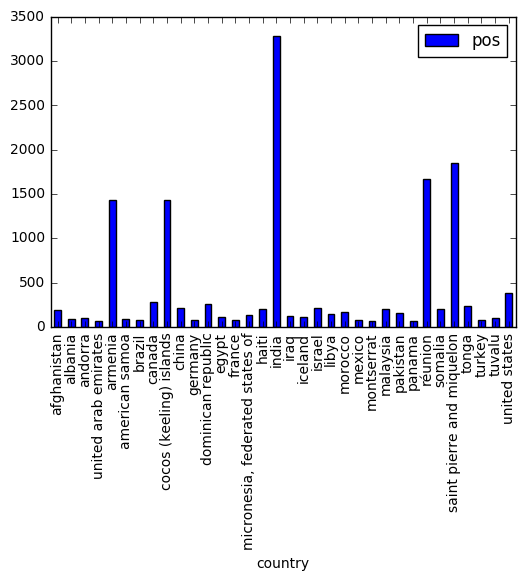

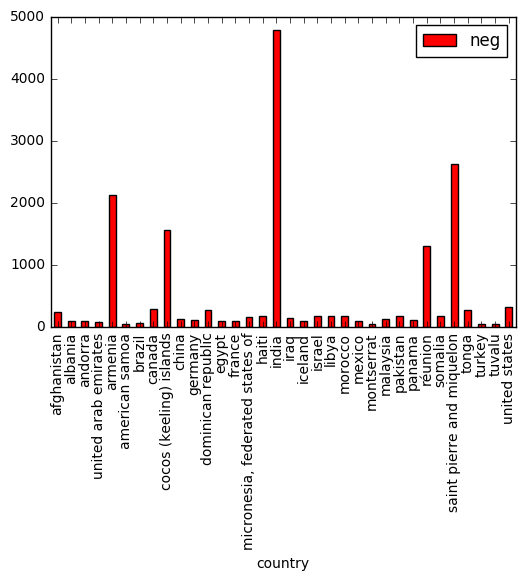

In [221]:
sentiment_per_country_pos.plot.bar(y="pos")
sentiment_per_country_pos.plot.bar(y="neg", color="r")
plt.show()

In [223]:
from nltk.corpus import opinion_lexicon
pos_lex = opinion_lexicon.positive()
neg_lex = opinion_lexicon.negative()

In [230]:
sentiment_df = pd.DataFrame(columns=["sentiment", "count_pos", "count_neg"])

i = 0
for email in emails.RawText:
    tokens = nltk.word_tokenize(email)
    count_pos = np.sum(np.in1d(tokens, pos_lex))
    count_neg = np.sum(np.in1d(tokens, neg_lex))
    
    if count_pos > count_neg:
        sent = 1
    else:
        sent = -1
    
    sentiment_df.loc[i] = (sent, count_pos, count_neg)
    i += 1

In [234]:
sentiment_df.to_csv("sentiment_Liu_Hu.csv")

In [235]:
sentiment_df = pd.read_csv("./sentiment_Liu_Hu.csv", index_col=0)

In [236]:
sentiment_df.describe()

,sentiment,count_pos,count_neg
count,7945.000000,7945.000000,7945.000000
mean,-0.033103,7.453241,5.973317
std,0.999515,20.230864,19.485975
min,-1.000000,0.000000,0.000000
25%,-1.000000,0.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,1.000000,6.000000,3.000000
max,1.000000,517.000000,459.000000


In [237]:
countries = [(country.name.lower(), country.alpha_2.lower(), country.alpha_3.lower()) for country in pycountry.countries]

In [238]:
sentiment_per_country = pd.DataFrame(columns=["country", "pos","neg"]).set_index("country")

In [239]:
for name, _, _ in countries:
    sentiment_per_country.loc[name] = 0

In [241]:
i = 0
for email in emails.RawText:
    add = 0
    sentiment = sentiment_df.loc[i]["sentiment"]
    
    tokens = nltk.word_tokenize(email)
    nouns = keep_nouns(tokens, ["NN", "NNP", "NNPS"])
    country_found = ["norway"]
    # find countries
    for noun in nouns:
        lc_noun = noun.lower()
        index = 0
        for name, a2, a3 in countries:
            if name not in country_found and (lc_noun == name or lc_noun == a2 or lc_noun == a3):
                country_found.append(name)
                if sentiment >= 0:
                    sentiment_per_country.pos.loc[name] += 1
                if sentiment < 0:
                    sentiment_per_country.neg.loc[name] += 1
    i += 1

In [242]:
sentiment_per_country.describe()

,pos,neg
count,249.000000,249.000000
mean,71.489960,66.662651
std,330.883204,332.908684
min,0.000000,0.000000
25%,2.000000,1.000000
50%,8.000000,8.000000
75%,31.000000,25.000000
max,3812.000000,4085.000000


In [214]:
sentiment_per_country_pos = sentiment_per_country[(sentiment_per_country.pos > 67) | (sentiment_per_country.neg > 76)]

In [215]:
sentiment_per_country_pos.shape

(34, 2)

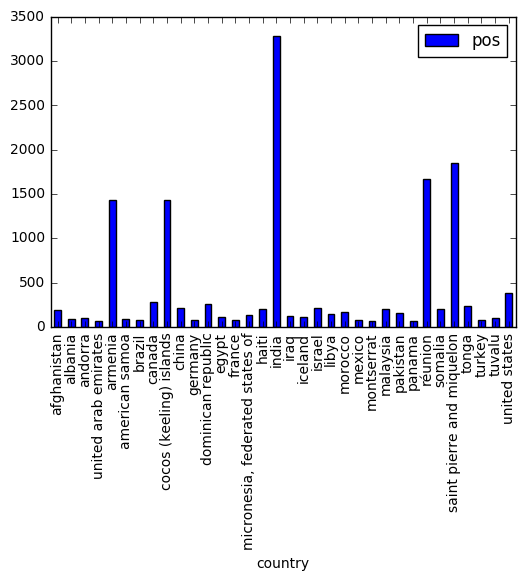

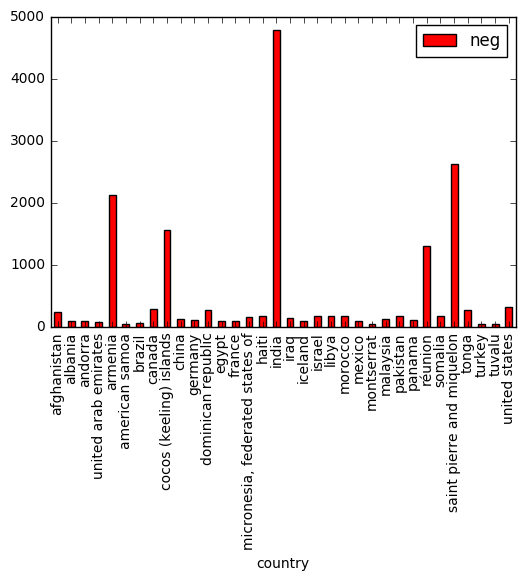

In [221]:
sentiment_per_country_pos.plot.bar(y="pos")
sentiment_per_country_pos.plot.bar(y="neg", color="r")
plt.show()